### Imports

In [1]:
import numpy as np
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
from biotuner.dictionaries import *
import matplotlib.pyplot as plt
import pytuning.visualizations.scales
from pytuning.visualizations.scales import consonance_matrix
import csv
import os
import time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

pygame 2.1.2 (SDL 2.0.18, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Biotuner examples of tuning construction

This notebook is intended to demonstrate the use of the biotuner for tuning construction. To do so, we will explore how different tuning construction methods developed in music theory can be integrated with electrophysiological signal processing. 

The terms ''*tuning*'' and ''*scale*'' will be used interchangeably, referring to a series of ratios that subdivides an octave.

### Table of content

1. [Spectral peaks extraction](#1-spectral-peaks-extraction)
2. [Deriving tuning from peaks ratios](#2-deriving-tuning-from-peaks-ratios)
3. [Dissonance curve](#3-dissonance-curve)
4. [Harmonic entropy](#4-harmonic-entropy)
5. [Classical tuning creation](#5-classical-tuning-creation)

    5.1. [Euler-Fokker Genera](#51-euler-fokker-genera)
    
    5.2. [Harmonic scale](#52-harmonic-scale)
        
        5.2.1. Using harmonic recurrence
        5.2.2. Using inter-harmonic concordance

6. [Scale reduction](#6-scale-reduction)
7. [Exporting scale in scala format](#7-exporting-scale-in-scala-format)
8. [Plotting consonance matrix for a specific scale](#8-plotting-consonance-matrix-for-a-specific-scale)
9. [Computing scale metrics](#9-computing-scale-metrics)
10. [Visualizing ratios with Lissajous curves](#10-visualizing-ratios-with-lissajous-curves)
11. [Listening to scales](#11-listening-to-scales-and-chords)

## 1. Spectral peaks extraction

### Load dataset

In [2]:
data = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')

### Extract spectral peaks

The first step is to initialize the biotuner object by calling *compute_biotuner* and then applying the method *peaks_extraction*. 

The *peaks_function* argument determines how spectral peaks are extracted. Here the 'fixed' method is used, where predetermined frequency bands are used to find one spectral peak associated with each band.

There is no minimum size for time series. However, keep in mind that the minimum frequency that can be observed using spectral decomposition is dependant on the length of your time series. For example, if the sampling frequency equals 1000Hz, time series shorter than 1 second will not allow for peak extraction below 2Hz. Also, note that the *precision* argument influences the size of the fft and higher precision requires longer time series (e.g. 0.1Hz of precision at 1000Hz of sampling frequency requires 10 seconds of signal).

In [24]:
# Define frequency bands for peaks_function = 'fixed'
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 18], [18, 30], [30, 45]] 

# Select a single time series
data_ = data[28]
start = time.time()

# Initialize biotuner object
biotuning = compute_biotuner(sf = 1000, peaks_function = 'fixed', precision = 0.5, n_harm = 10)

# Extract spectral peaks
biotuning.peaks_extraction(data_, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 30, n_peaks=5,
                          graph=False, min_harms=2)

stop = time.time()
print(stop-start)

Index_max: all zeros indicate 1/f trend [0, 7, 2, 11, 1, 17]
Number of peaks : 6
0.011924505233764648


In [25]:
# Print the extracted peaks
biotuning.peaks

array([ 1. ,  6.5,  8. , 17.5, 18.5, 38.5])

Now that we have shown how spectral peaks can be extracted, we will use these peaks as the basis for the organisation of musical structures. We will show how to derive tunings based on the harmonicity of spectral peaks, expressed as the simplicity of their frequency ratios.

## 2. Deriving tuning from peaks ratios

The simpliest way to derive a tuning from spectral peaks is to use their ratios as steps for dividing the octave. An attribute of the biotuner object provides this information.

In [26]:
biotuning.peaks_ratios 

[1.0405405405405406,
 1.0571428571428572,
 1.09375,
 1.1,
 1.15625,
 1.203125,
 1.2307692307692308,
 1.3461538461538463,
 1.4230769230769231,
 1.4807692307692308,
 1.625,
 2.0]

You can also derive a tuning from extended peaks ratios as well as from extended peaks ratios with higher consonance levels. Extended peaks correspond to a set of frequencies based on the harmonic congruence of spectral peaks.

In [27]:
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 20, 
                          cons_limit = 0.129, ratios_extension = True, scale_cons_limit = 0.129) 
print(np.sort(biotuning.extended_peaks_ratios))

Number of extended peaks :  11
[1.04 1.06 1.09 1.1  1.16 1.2  1.23 1.25 1.3  1.35 1.38 1.41 1.42 1.48
 1.49 1.5  1.62 1.85 2.  ]


Since the tuning from extended peaks might have a large number of steps, we could keep only the most consonant ratios. To do so, we adjust the 'scale_cons_limit' value:

Comparisons with familiar ratios:
        
        #Unison-frequency ratio 1:1 yields a value of 2
        Octave-frequency ratio 2:1 yields a value of 1.5
        Perfect 5th-frequency ratio 3:2 yields a value of 0.833
        Perfect 4th-frequency ratio 4:3 yields a value of 0.583
        Major 6th-frequency ratio 5:3 yields a value of 0.533
        Major 3rd-frequency ratio 5:4 yields a value of 0.45
        Minor 3rd-frequency ratio 5:6 yields a value of 0.366
        Minor 6th-frequency ratio 5:8 yields a value of 0.325
        Major 2nd-frequency ratio 8:9 yields a value of 0.236
        Major 7th-frequency ratio 8:15 yields a value of 0.192
        Minor 7th-frequency ratio 9:16 yields a value of 0.174
        Minor 2nd-frequency ratio 15:16 yields a value of 0.129

In [28]:
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 30, 
                          cons_limit = 0.1, ratios_extension = True, scale_cons_limit = 0.129) 
print(biotuning.extended_peaks_ratios_cons)

biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 30, 
                          cons_limit = 0.1, ratios_extension = True, scale_cons_limit = 0.236) 
print(biotuning.extended_peaks_ratios_cons)

Number of extended peaks :  14
[1.083 1.1   1.231 1.25  1.375 1.5   1.625 2.   ]
Number of extended peaks :  14
[1.25 1.5  2.  ]


## 3. Dissonance curve

The dissonance curve has been introduced by William Sethares showing how the harmonic structure that constitutes a timbre can be reflected in scale construction, allowing to find tunings that will match the timbral structure. I strongly recommend reading his book [Tuning, Timbre, Spectrum and Scale](https://sethares.engr.wisc.edu/ttss.html).

The dissonance curve takess as input list of peaks and their associated amplitudes. Since providing less than 6 spectral peaks would lead to less interesting dissonance curve, the method ''peaks_extension'' provides a way to extend the number of peaks based on the harmonic_fit function (see biotuner.py)

peaks_extension methods: 
['harmonic_fit', 'consonant', 'multi_consonant', 'consonant_harmonic_fit', 'multi_consonant_harmonic_fit']

Number of extended peaks :  11


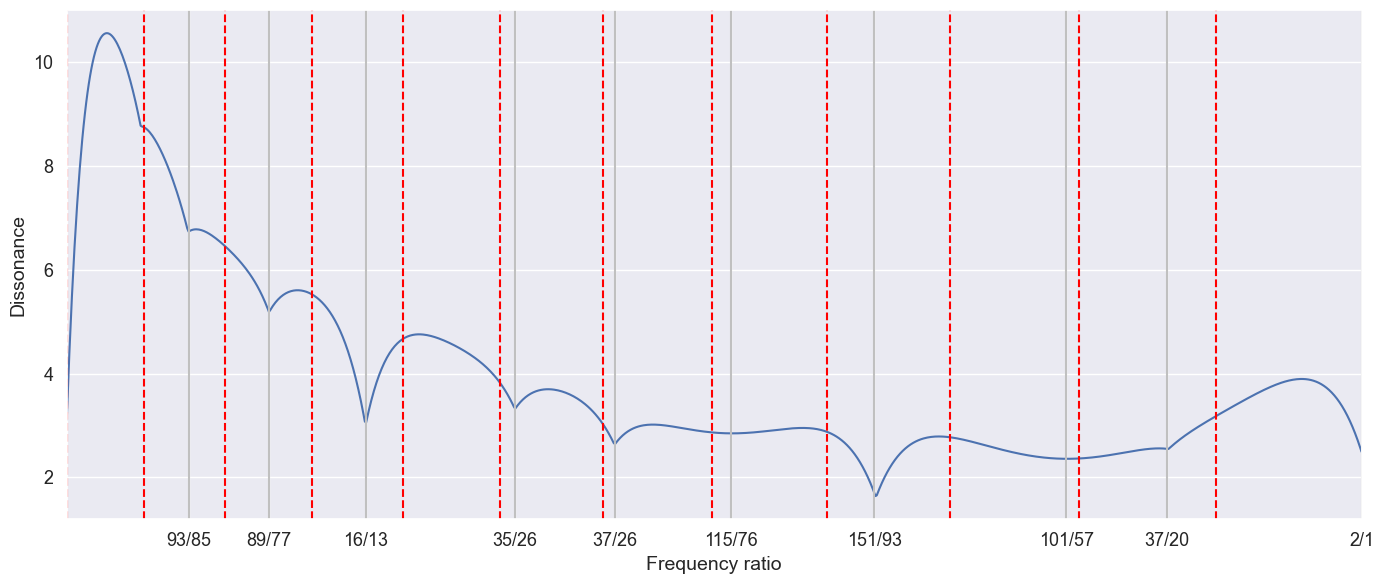

In [29]:
# Extend spectral peaks based on their inter-harmonic concordance
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 20, cons_limit = 0.05, 
                          ratios_extension = True, scale_cons_limit = 0.1)
# Compute the dissonance curve
biotuning.compute_diss_curve(plot = True, input_type = 'extended_peaks', euler_comp = False, denom = 100, max_ratio = 2, n_tet_grid = 12)


In [30]:
print('Dissonance curve metrics:', biotuning.scale_metrics)
print('Dissonance curve tuning:', biotuning.diss_scale)
print('Dissonance curve consonant tuning:', biotuning.diss_scale_cons)

Dissonance curve metrics: {'diss_euler': 'NaN', 'dissonance': 3.9844954535203048, 'diss_harm_sim': 5.038404472654177, 'diss_n_steps': 10}
Dissonance curve tuning: [1.0941176470588236, 1.155844155844156, 1.2307692307692308, 1.3461538461538463, 1.4230769230769231, 1.513157894736842, 1.6236559139784945, 1.7719298245614035, 1.85, 2.0]
Dissonance curve consonant tuning: [1.231 2.   ]


In [31]:
### If you want the tuning in fraction
scale_frac, num, denom = scale2frac(biotuning.diss_scale, maxdenom = 1000)
scale_frac

[93/85, 89/77, 16/13, 35/26, 37/26, 115/76, 151/93, 101/57, 37/20, 2]

## 4. Harmonic entropy

[Harmonic entropy]('https://en.xen.wiki/w/Harmonic_entropy') is a simple model to quantify the extent to which musical chords exhibit various psychoacoustic effects, lumped together in a single construct called psychoacoustic concordance.

The *compute_harmonic_entropy* method takes as input a list of ratios.

If *input_type* is set to '*peaks*' or *'extended_peaks'*, their ratios will be used.
Other input types use extended ratios : see biotuner ref.

'extended_ratios_inc'  (increments of the ratios in the form of *r^1, r^2, r^3, ... r^n*)

'extended_ratios_inc_fit' (harmonic fit between the ratios increments)

'extended_ratios_harm' (harmonics of the ratios in the form *rx1, rx2, rx3, ... rxn*)


Number of peaks : 5
Number of extended peaks :  24


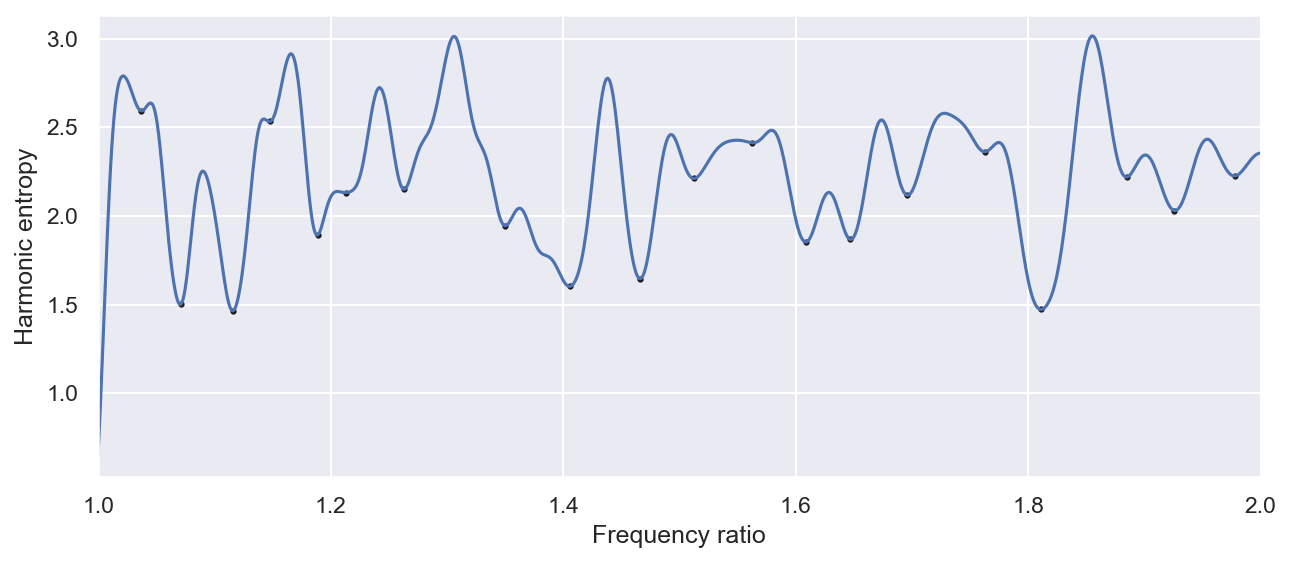

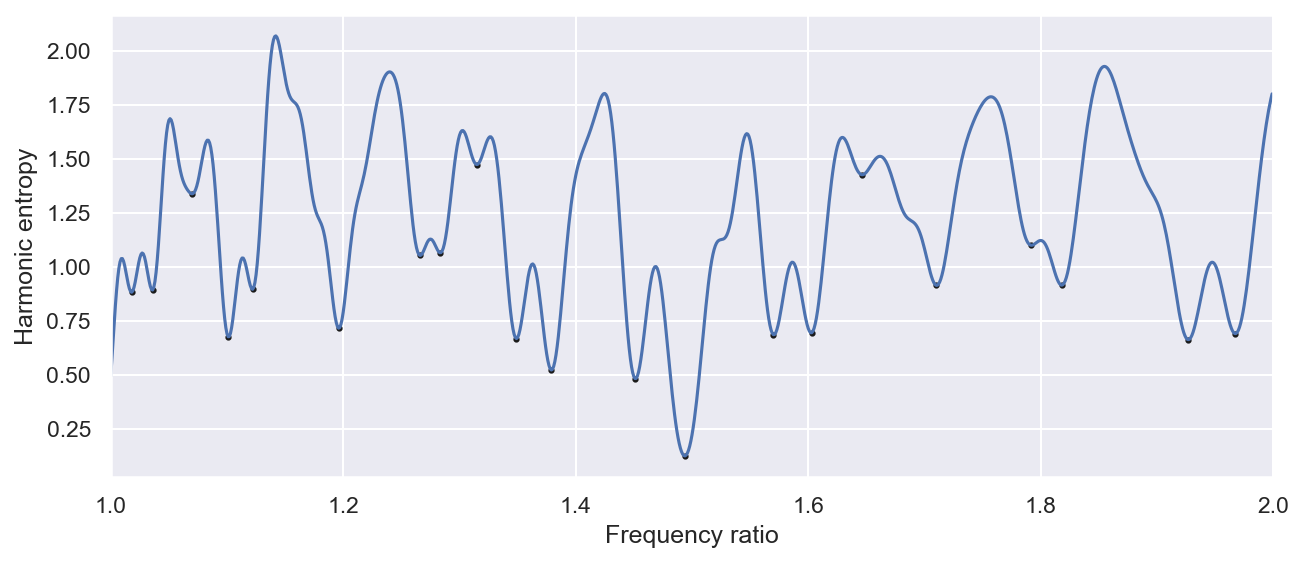

In [32]:
# Initialize biotuner object, specifying that you want ratios increments and harmonics to be computed
biotuning = compute_biotuner(sf = 1000, peaks_function = 'harmonic_recurrence', precision = 0.5, n_harm = 30,
                             ratios_inc=True, ratios_harms=True, ratios_inc_fit=True)
# Extract spectral peaks
biotuning.peaks_extraction(data_, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 30, n_peaks=5,
                          graph=False, min_harms=2)
# compute the extended peaks by finding inter-harmonic concordance.
biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult',  n_harm = 30, 
                          cons_limit = 0.1, ratios_extension = True)
# compute the harmonic entropy curve as a function of extended ratios increments.
biotuning.compute_harmonic_entropy(input_type = 'extended_ratios_inc', plot_entropy = True, octave = 2, rebound = False, 
                                   scale_cons_limit = 0.01, sub=False)

# compute the harmonic entropy curve as a function of extended ratios harmonics.
biotuning.compute_harmonic_entropy(input_type = 'extended_ratios_harms', plot_entropy = True, octave = 2, rebound = False, 
                                   scale_cons_limit = 0.01, sub=False)

In [33]:
print('Harmonic entropy metrics:', biotuning.scale_metrics)
print('Harmonic entropy tuning:', biotuning.HE_scale)
print('Harmonic entropy consonant tuning:', biotuning.HE_scale_cons)

Harmonic entropy metrics: {'HE': 1.2165484571397156, 'HE_n_steps': 21, 'HE_harm_sim': 0.5818470682340359}
Harmonic entropy tuning: [1.018 1.036 1.07  1.101 1.122 1.196 1.266 1.283 1.315 1.349 1.379 1.451
 1.494 1.57  1.603 1.646 1.71  1.792 1.818 1.927 1.967]
Harmonic entropy consonant tuning: [1.07  1.57  1.71  1.792]


In [34]:
# If you want the tuning in fraction
scale_frac, num, denom = scale2frac (biotuning.HE_scale, maxdenom = 100)
print(scale_frac)

[57/56, 86/83, 107/100, 109/99, 46/41, 61/51, 119/94, 68/53, 96/73, 58/43, 131/95, 74/51, 124/83, 157/100, 109/68, 107/65, 171/100, 138/77, 20/11, 185/96, 179/91]


## 5. Classical tuning creation

We will see in this section how to use spectral peaks and their ratios to derive tunings based on Euler-Fokker Genera, Harmonic positions and Generator Intervals

In [68]:
# Initialize biotuner object
biotuning_class_scales = compute_biotuner(sf = 1000, peaks_function = 'harmonic_recurrence', precision = 0.5,
                                          n_harm = 15, ratios_n_harms = 5, ratios_inc_fit = True,
                                          ratios_inc = True) 
# Extract spectral peaks
biotuning_class_scales.peaks_extraction(data_, ratios_extension = True, max_freq = 50)

Number of peaks : 5


### 5.1. Euler-Fokker Genera

[Euler-Fokker genera](https://en.wikipedia.org/wiki/Euler%E2%80%93Fokker_genus) are musical scale in just intonation whose pitches can be expressed as products of some of the members of some multiset of generating prime factors. 

In [64]:
# Use peaks as generators (using method)
print('Generators :', biotuning_class_scales.peaks)
biotuning_class_scales.euler_fokker_scale()

Generators : [ 2.   6.5  8.   3.5 11.5]


[1, 33/32, 11/8, 3/2, 2]

In [69]:
from biotuner.scale_construction import euler_fokker_scale

# compute extended peaks
biotuning_class_scales.peaks_extension(method = 'harmonic_fit', harm_function = 'mult', 
                                       n_harm = 10, cons_limit = 0.1, ratios_extension = True)

# Use extended peaks as generators (using function)
EFG = euler_fokker_scale(biotuning_class_scales.extended_peaks)

# print the scale steps with associated names
scale_interval_names(EFG, reduce = False)

Number of extended peaks :  8


[[1, 'Unison'],
 [33/32, 'Thrty-third Harmonic'],
 [9/8, 'Pythagorean Major Second'],
 [77/64, 'Seventy-seventh Harmonic'],
 [21/16, '21st Harmonic'],
 [693/512, None],
 [11/8, 'Eleventh Harmonic'],
 [3/2, 'Perfect Fifth'],
 [99/64, 'Ninety-ninth Harmonic'],
 [7/4, 'Septimal Minor Seventh'],
 [231/128, None],
 [63/32, 'Sixty-third Harmonic'],
 [2, 'Octave']]

### 5.2. Harmonic scale

Harmonic scales are constructed by transforming a set of harmonic positions into ratios falling between the unison (1) and the octave (2). For example, using the harmonics 3, 5 and 7 would yields a scale of 1, 1.5, 1.25 and 1.75, since 3/2=1.5, 5/2^2 = 1.25 and 7/2^2 = 1.75



##### 5.2.1. Using harmonic recurrence

The harmonic recurrence method computes all peaks of the spectrum, and keeps peaks for which a maximum of other peaks are harmonics. This method gives as an ouput the peaks and the positions of congruent harmonics. The *max_freq* argument determines the maximum frequency that can be choose as a peak. The *min_harms* argument indicates the minimum number of congruent harmonics to keep the peak. 

In [70]:
# Initialize biotuner object
biotuning_harm_peaks = compute_biotuner(sf = 1000, peaks_function = 'harmonic_recurrence', precision = 0.5) 

# Extract spectral peaks with minimum of 2 recurrent harmonics
biotuning_harm_peaks.peaks_extraction(data_, min_freq = 5, max_freq = 20, min_harms = 2, harm_limit = 128)
print(biotuning_harm_peaks.all_harmonics)

# Extract spectral peaks with minimum of 4 recurrent harmonics
biotuning_harm_peaks.peaks_extraction(data_, min_freq = 5, max_freq = 20, min_harms = 4, harm_limit = 128)
print(biotuning_harm_peaks.all_harmonics)

Number of peaks : 5
[ 2.  3.  5.  6.  7.  8.  9. 10. 12. 14. 18. 19. 20. 21. 23. 30. 31. 37.
 41. 42. 45. 52. 60. 62. 66. 67. 71. 73.]
Number of peaks : 3
[ 2.  5.  6.  7.  8.  9. 10. 12. 18. 19. 20. 21. 30. 31. 42. 45. 52. 60.
 62. 66. 67. 71. 73.]


In [71]:
# deriving harmonic tuning from recurrent harmonics
harm_tuning = harmonic_tuning(biotuning_harm_peaks.all_harmonics)
print(harm_tuning)

[1.03125, 1.046875, 1.109375, 1.125, 1.140625, 1.1875, 1.25, 1.3125, 1.40625, 1.5, 1.625, 1.75, 1.875, 1.9375, 2.0]


Instead of using all the harmonics, we can use the harmonic positions of a single peak to generate a tuning

In [76]:
# find harmonic positions of first peak
harmonics = biotuning_harm_peaks.harm_peaks_fit[0][1]

# compute harmonic tuning
harm_peak_tuning = harmonic_tuning(harmonics)

# print results
print('Harmonics', [int(x) for x in harmonics])
print('Tuning', harm_peak_tuning)

Harmonics [5, 7, 8, 19, 42, 45, 52, 62, 66, 67, 71, 73]
Tuning [1.03125, 1.046875, 1.109375, 1.140625, 1.1875, 1.25, 1.3125, 1.40625, 1.625, 1.75, 1.9375, 2.0]


We will now compute the harmonicity metrics associated with the tuning

In [80]:
from biotuner.metrics import tuning_to_metrics
metrics = tuning_to_metrics(harm_peak_tuning)
metrics

{'sum_p_q': 708,
 'sum_distinct_intervals': 132,
 'metric_3': 89.5821733821734,
 'sum_p_q_for_all_intervals': 12718,
 'sum_q_for_all_intervals': 5238,
 'harm_sim': 20.53,
 'matrix_harm_sim': 7.408307919171108,
 'matrix_cons': 0.07770664568642607,
 'matrix_denom': 44.07575757575758}

##### 5.2.2. Using inter-harmonic concordance

This method constructs the tuning based on the positions of the congruent harmonics of peaks

In [81]:
harm_tuning2 = biotuning.harmonic_fit_tuning(n_harm =128, bounds = 0.1, n_common_harms = 20)
print(harm_tuning2)


[1.015625, 1.21875, 1.25, 1.3125, 1.4375, 1.5, 1.625, 1.75, 2.0]


In [82]:
metrics = tuning_to_metrics(harm_tuning2)
metrics

{'sum_p_q': 325,
 'sum_distinct_intervals': 56,
 'metric_3': 83.9904761904762,
 'sum_p_q_for_all_intervals': 3231,
 'sum_q_for_all_intervals': 1333,
 'harm_sim': 32.37,
 'matrix_harm_sim': 16.494247248323333,
 'matrix_cons': 0.1792047469187415,
 'matrix_denom': 22.694444444444443}

### 5.3. Scale from generator interval

In [ ]:
data_gen = data[30] # Define data (single time series)


#biotuning = biotuner(sf = 1000, peaks_function = 'EEMD', precision = 0.1, n_harm = 10,
#                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

biotuning.peaks_extraction(data_gen, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 50)

ratios, cons = consonant_ratios(biotuning.peaks, limit = 0.01, input_type = 'peaks', metric = 'harmsim') #finding the intervals
ratio_arg = np.argmax(cons)
cons_ratio = ratios[ratio_arg]

Index_max: all zeros indicate 1/f trend [0, 1, 1, 0, 0, 3]
Number of peaks : 6


In [ ]:
gen_interval_tuning = pytuning.scales.create_equal_interval_scale(ratios[0], scale_size = 11, number_down_intervals = 6, octave = 2)
gen_interval_tuning = [float(x) for x in gen_interval_tuning]

frac, _, _ = scale2frac(gen_interval_tuning, 64) # Transform the ratios into fractions with controlled maximum denominator.
                                                 # Using smaller denominator limit will maximize the chance to find intervalic names in the dictionary
frac2, _, _ = scale2frac(gen_interval_tuning, 16)

print(scale_interval_names(frac, reduce = False),'\n\n', scale_interval_names(frac2, reduce = False))

[[1, 'Unison'], [21/20, 'Septimal Chromatic Semitone'], [43/39, None], [22/19, None], [62/51, None], [94/63, None], [47/30, None], [51/31, None], [19/11, None], [78/43, None], [40/21, None], [2, 'Octave']] 

 [[1, 'Unison'], [17/16, 'Minor Diatonic Semitone'], [11/10, "Ptolemy's second"], [15/13, None], [17/14, 'Superminor Third'], [3/2, 'Perfect Fifth'], [11/7, 'Undecimal Minor Sixth'], [23/14, None], [19/11, None], [29/16, 'Twenty-ninth Harmonic'], [21/11, None], [2, 'Octave']]


In [ ]:
gen_interval_tuning = [np.round(float(t), 3) for t in gen_interval_tuning]
metrics = tuning_to_metrics(gen_interval_tuning)
metrics

{'sum_p_q': 8501,
 'sum_distinct_intervals': 110,
 'metric_3': 50.8163414525635,
 'sum_p_q_for_all_intervals': 208545,
 'sum_q_for_all_intervals': 86194,
 'harm_sim': 17.97,
 'matrix_harm_sim': 2.508154516722921,
 'matrix_cons': 0.03277723059872621,
 'matrix_denom': 687.8636363636364}

## 6. Scale reduction

In [ ]:
from biotuner.scale_construction import tuning_reduction
# scale reduction based on harmonicity between ratios
tuning_metric, reducted_tuning, mode_metric = tuning_reduction(biotuning.peaks_ratios, mode_n_steps = 4, 
                                                            function = dyad_similarity, ratio_type='pos_harm')
tuning_metric, np.sort(reducted_tuning), mode_metric

(18.261957371332368,
 array([1.3125, 1.7143, 1.75  , 1.9688]),
 23.895050746400297)

## 7. Exporting scale in scala format

In [ ]:
create_SCL(biotuning.HE_scale, 'Harmonic_entropy_scale')
create_SCL(biotuning.diss_scale, 'Dissonance_curve_scale')
create_SCL(biotuning.peaks_ratios, 'Peaks_ratios_scale')
create_SCL(biotuning.extended_peaks_ratios_cons, 'consonant_extended_peaks_ratios_scale')


## 8. Plotting consonance matrix for a specific scale

The metric_function can be set to:
- None : the denominator of the normalized ratio
- dyad_similarity : similarity with the harmonic series
- consonance : (a+b)/(a*b)

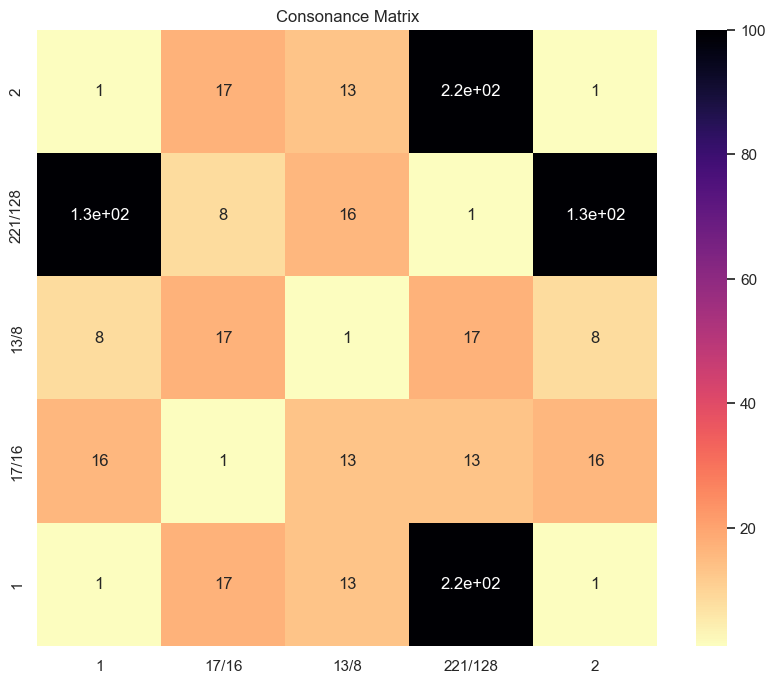

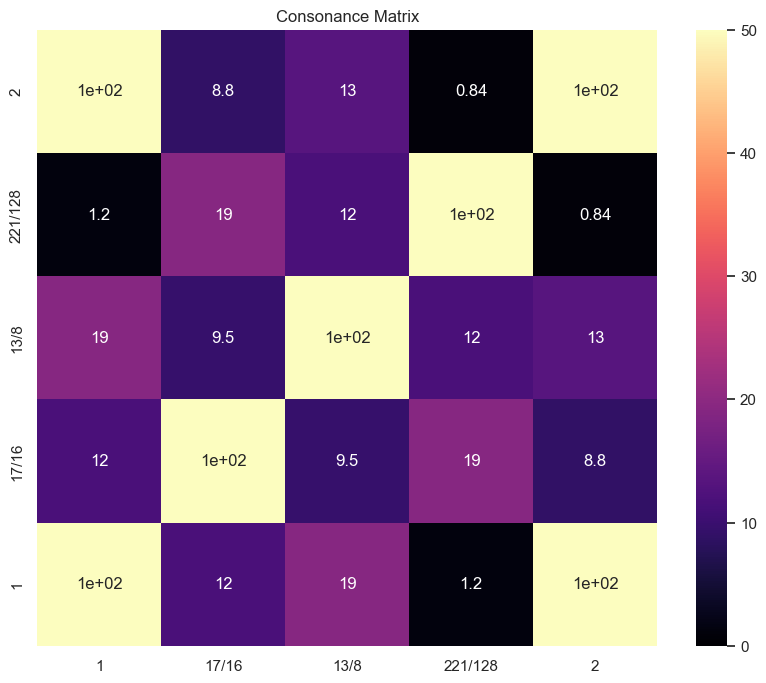

In [61]:
scale = biotuning.euler_fokker_scale(method='extended_peaks', octave = 2)
cons_matrix = consonance_matrix(scale, vmin = 1, vmax = 100, cmap = 'magma_r', fig = None)
cons_matrix_harmsim = consonance_matrix(scale, metric_function = dyad_similarity,
                                        vmin = 0, vmax = 50, cmap = 'magma', fig = None)

## 9. Computing scale metrics 

#### From peaks ratios

In [63]:
from biotuner.metrics import tuning_to_metrics
metrics_peaks = tuning_to_metrics(biotuning.peaks_ratios)
metrics_peaks

c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'sum_p_q': 827,
 'sum_distinct_intervals': 68,
 'metric_3': 88.4222688422688,
 'sum_p_q_for_all_intervals': 81765,
 'sum_q_for_all_intervals': 33811,
 'harm_sim': 15.81,
 'matrix_harm_sim': 4.043722630611277,
 'matrix_cons': 0.041454254223088405,
 'matrix_denom': 318.3181818181818}

#### From dissonance curve tuning

In [64]:
metrics_peaks = tuning_to_metrics(biotuning.diss_scale)
metrics_peaks

{'sum_p_q': 1150,
 'sum_distinct_intervals': 90,
 'metric_3': 33.6516166107951,
 'sum_p_q_for_all_intervals': 514290,
 'sum_q_for_all_intervals': 212787,
 'harm_sim': 14.53,
 'matrix_harm_sim': 1.9013309452385887,
 'matrix_cons': 0.019501600064712143,
 'matrix_denom': 2151.688888888889}

## 10. Visualizing ratios with Lissajous curves

#### thanks to https://glowingpython.blogspot.com/2011/12/lissajous-curves.html

[21/20, 15/14, 9/8, 6/5, 9/7, 21/16, 3/2, 8/5, 12/7, 7/4, 15/8, 63/32]


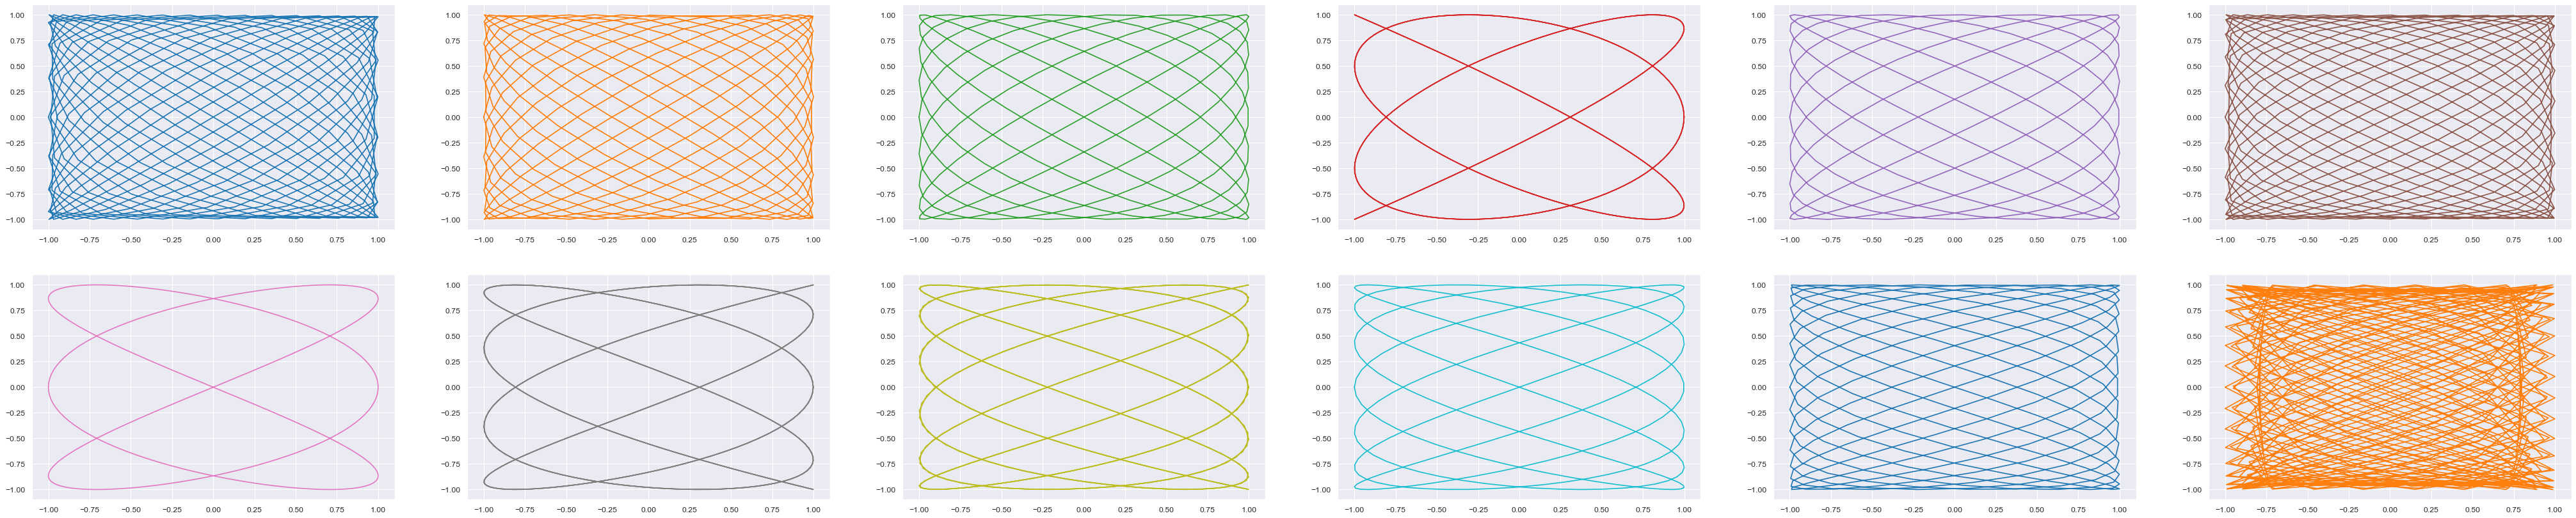

In [85]:
from biotuner.vizs import lissajous_curves
tuning = biotuning.harmonic_fit_tuning
tuning = biotuning.peaks_ratios
lissajous_curves(tuning)

[1, 21/20, 551/500, 579/500, 152/125, 373/250, 1567/1000, 329/200, 216/125, 907/500, 381/200, 2]


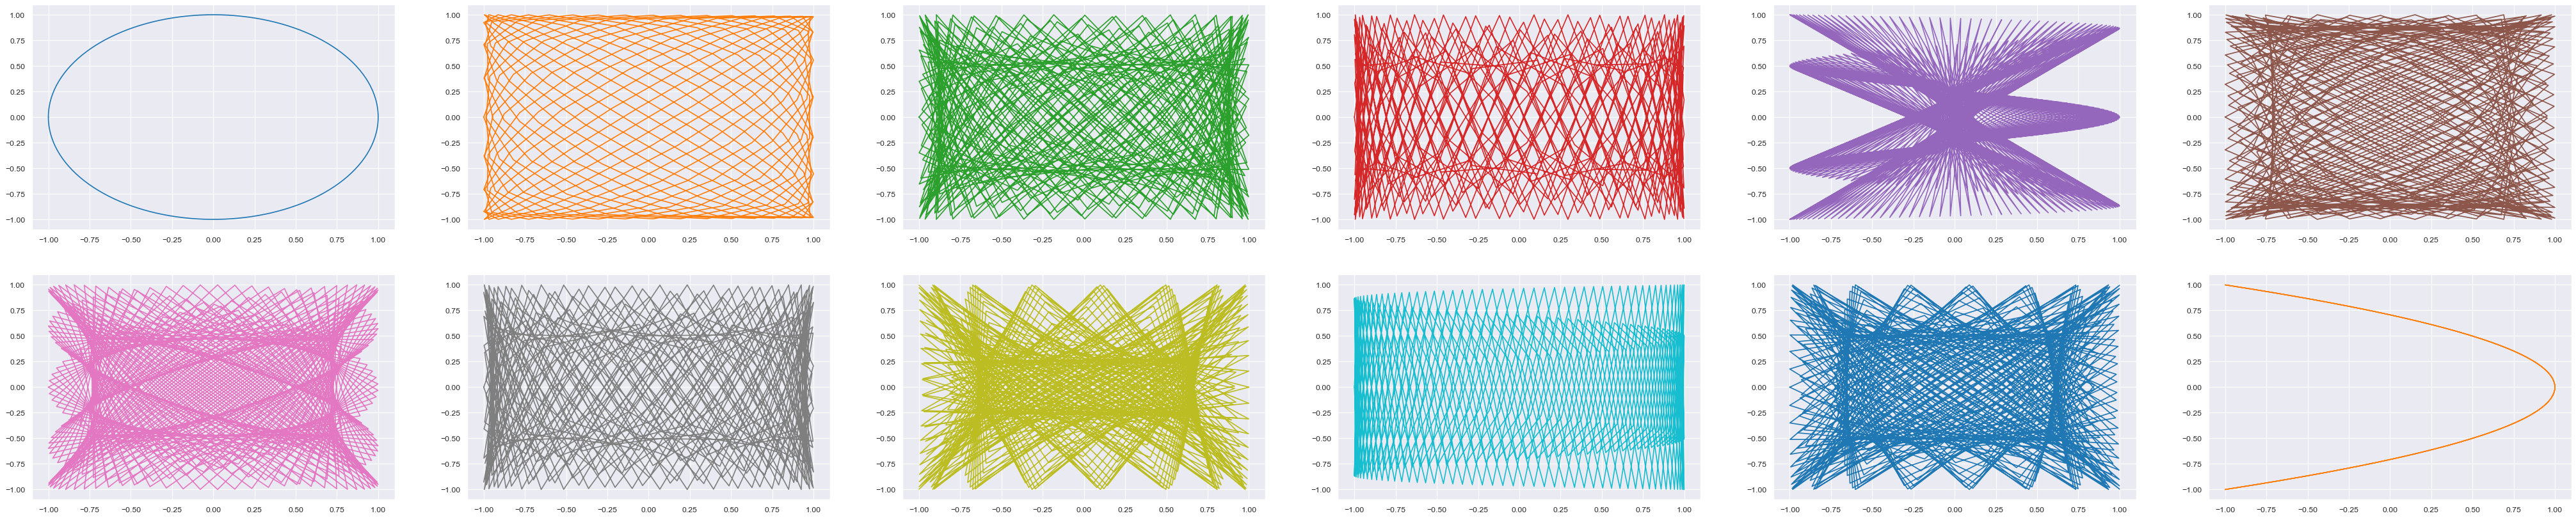

In [86]:
lissajous_curves(gen_interval_tuning)

##### Congruent N-TET derived from multiple ratios

## 11. Listening to scales and chords

In [ ]:
listen_scale(biotuning.diss_scale, 250, 500)

Scale: [1.127906976744186, 1.178082191780822, 1.216867469879518, 1.2717391304347827, 1.3770491803278688, 1.4339622641509433, 1.5, 1.5714285714285714, 1.6419753086419753, 1.7849462365591398, 1.9148936170212767, 2.0]
250
281.9767441860465
294.52054794520546
304.2168674698795
317.9347826086957
344.2622950819672
358.49056603773585
375.0
392.85714285714283
410.4938271604938
446.23655913978496
478.72340425531917
500.0


In [ ]:
listen_chords(chords_bounded[:], 200, 500)

Chords: [[1.0, 1.0, 1.1153846153846154, 1.1153846153846154], [1.0, 1.0833333333333333, 1.25, 1.75], [1.0, 1.1111111111111112, 1.3703703703703705, 1.5185185185185186], [1.0, 1.5, 1.5789473684210527, 1.736842105263158], [1.0, 1.0625, 1.375, 1.9375], [1.0, 1.2105263157894737, 1.263157894736842, 1.4210526315789473], [1.0, 1.1320754716981132, 1.3396226415094339, 1.5660377358490567]]


In [ ]:
listen_chords(chords_bounded2[:], 200, 500)

Chords: [[1.0, 1.0, 1.1153846153846154, 1.1153846153846154], [1.0, 1.75, 2.1666666666666665, 2.5], [1.0, 1.1111111111111112, 1.3703703703703705, 1.5185185185185186], [1.0, 1.5, 1.736842105263158, 3.1578947368421053], [1.0, 1.375, 2.1875, 3.8125], [1.0, 1.2105263157894737, 1.263157894736842, 1.4210526315789473], [1.0, 1.5660377358490567, 2.2641509433962264, 2.6792452830188678]]


### MOS scales

In [ ]:
mediant, mediant_frac, gen_interval, gen_interval_frac, MOS_sig, invert_MOS_sig = tuning_range_to_MOS(5/7, 9/29,
                                                                                                    max_denom_out = 64)
mediant_frac, gen_interval_frac, MOS_sig

5 7 9 29


(7/18, 55/42, [29, 7])